In [35]:
import os
from matplotlib import pyplot as plt
import numpy as np
import h5py
import pandas as pd
from pyproj import Proj


In [36]:
df = pd.read_pickle('../data/all-power-1.pkl')

In [37]:
def indicesForCoord(coords, lat_index, lon_index):
    dset_coords = coords
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

In [6]:
coords = np.load('../data/nrel-coords.npy')

In [9]:
nrel_indexs = [indicesForCoord(coords, lat, lon) for (lat,lon) in zip(df['latitude'],df['longitude'])]

In [52]:
np.count_nonzero([x[1] <= 0 for x in nrel_indexs])

0

In [53]:
nrel_i0 = [x[0] for x in nrel_indexs]
nrel_i1 = [x[1] for x in nrel_indexs]

In [103]:
len(nrel_indexs)

993

In [52]:
#wind_list = []
#idx = 248
while idx < len(nrel_indexs):
    print(idx)
    i,j = nrel_indexs[idx]
    wind_list.append((idx,nrel['f']['windspeed_80m'][:,i,j]))
    idx = idx + 1

In [34]:
#fnp.save('../data/all-wind-1/wind/all_time248:992.npy',np.array([x[1] for x in wind_list]).astype(np.float))

In [31]:
print(idx,len(wind_list)+248 - idx)

744 0


In [110]:
61368*len(nrel_indexs)*(64/8/1000/1000)

487.507392

In [17]:
import sys
sys.path.append('/Users/kook/insight/windsite/src')
import imp
import wind
imp.reload(wind)
import wind
nrel = wind.setup_nrel()

In [75]:
features = ['elevation','mean_wind_speed', 'pow_curve','temperature']

In [18]:
feat_list = []
for idx,(i,j) in enumerate(nrel_indexs[900:993]):
    print(idx)
    feat_list.append(wind.idx_to_features(nrel,coords,(i,j),features,year = 2013))

0


NameError: name 'features' is not defined

In [105]:
len(feat_list)

200

In [107]:
#fnp.save('data/all-wind-1/features900:993.npy',np.array(feat_list).astype(np.float))

In [104]:
#np.count_nonzero(np.isnan(np.load('data/all-wind-1/features700:900.npy')))

2

In [35]:
np_data = f['windspeed_80m'][:,nrel_i0[1:3],nrel_i1[1:3]]

TypeError: Indexing elements must be in increasing order

In [28]:
f['windspeed_80m'].shape

(792, 1602, 2976)

In [108]:
nrel['f']['windspeed_80m'].shape

(61368, 1602, 2976)

487.507392

In [29]:
nrel_indexs[1]

(788, 1209)

In [27]:
nrel_indexs[1]

(788, 1209)

In [26]:
np_data.shape

(792, 2, 2976)

In [22]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
for mo in '01,03,04,05,06,07,08,09,10,11,12'.split(','):
    name = '2013-' + mo
    f = h5py.File('/Users/kook/mount/wtk-us/' + name + '.h5', 'r')
    #f = h5py.File('/Users/kook/mount/conus/v1.1.0/wtk_conus_2014.h5', 'r')
    #f = h5py.File('/Users/kook/mount/conus/v1.1.0/2014/wtk_conus_2014_80m.h5', 'r')
    c
    np.save('data/all-wind-1/wind/' + name + '.npy',np_data)

TypeError: Indexing elements must be in increasing order

# compare NREL capacity factor to pow_curve

In [41]:
coords[nrel_indexs[0]]

(38.031223, -102.53772)

In [44]:
techno_df = pd.read_csv('../data/nrel-techno-sites.csv')
techno_df.head()

,site_id,longitude,latitude,State,County,fraction_of_usable_area,power_curve,capacity,wind_speed,capacity_factor,full_timeseries_directory,full_timeseries_path
0,0,-117.147260,23.510410,Unknown,Unknown,1.0,offshore,16,6.07,0.169,0,0/0.nc
1,1,-93.946777,24.007446,Unknown,Unknown,1.0,offshore,16,7.43,0.302,0,0/1.nc
2,2,-97.482483,25.069138,Unknown,Unknown,1.0,offshore,16,8.19,0.375,0,0/2.nc
3,3,-97.463135,25.069443,Unknown,Unknown,1.0,offshore,16,8.19,0.375,0,0/3.nc
4,4,-97.443756,25.069763,Unknown,Unknown,1.0,offshore,16,8.19,0.376,0,0/4.nc


In [97]:
coords.shape

(1602, 2976)

In [100]:
def check_nrel_index(latlon_index):
    return latlon_index[0] < coords.shape[0] and latlon_index[1] < coords.shape[1]
is_valid_index = [check_nrel_index(latlon_index) for latlon_index in nrel_indexs]
np.count_nonzero(is_valid_index)

993

In [154]:
def find_techno_index_manhattan(latlon):
    diffs = (
        np.abs(techno_df['latitude']-latlon[0]),
        np.abs(techno_df['longitude']-latlon[1])
    )
    mindx = np.argmin(diffs[0]+diffs[1])
    if (np.isclose(diffs[0][mindx],0) & np.isclose(diffs[1][mindx],0)):
        return mindx
    else:
        return np.nan
def find_techno_index(latlon):
    #dists = [distance(latlon,tech_latlon) for tech_latlon in techno_latlons]
    sq_dists = (techno_df['latitude']-latlon[0])**2 + (techno_df['longitude']-latlon[1])**2
    mindx = np.argmin(sq_dists)
    #assert(mindx[0]==mindx[1])
    #print(diffs[0][mindx],diffs[1][mindx])
    return mindx

In [240]:
from geopy.distance import distance
techno_latlons = list(zip(techno_df['latitude'],techno_df['longitude']))
tidxs = [find_techno_index(coords[latlon_idx]) for latlon_idx in nrel_indexs ]
print(np.count_nonzero(np.isnan(tidxs)))
non_nan_tidxs = [i for i in tidxs if not np.isnan(i)]
wind_farm_techno_df = techno_df.iloc[tidxs].copy().reset_index().drop('index',axis=1)
#display(wind_farm_techno_df])
# print(len(wind_farm_techno_df))
wind_farm_techno_df['eia_id'] = df.reset_index()['eia_id']
#the following line is annoying 
#wind_farm_techno_df[wind_farm_techno_df['power_curve'] == 'offshore']['power_curve'] = 0 #offshore coded as 0
dgrid_distances = [distance(coords[latlon_idx],(wf_lat,wf_lon)).kilometers for latlon_idx,wf_lat,wf_lon in
                  zip(nrel_indexs,df['latitude'],df['longitude'])]

0


In [206]:
np.min(np.abs(wind_farm_techno_df['eia_id']-56800))

3

In [242]:
np.any(wind_farm_techno_df['eia_id'].to_numpy().astype(np.int) == 56800)

True

In [241]:
wind_farm_techno_df.set_index('eia_id').loc[56800]

site_id                             106451
longitude                         -70.8718
latitude                           42.2729
State                              Unknown
County                             Unknown
fraction_of_usable_area                  1
power_curve                       offshore
capacity                                16
wind_speed                            7.74
capacity_factor                      0.351
full_timeseries_directory              212
full_timeseries_path         212/106451.nc
Name: 56800, dtype: object

In [191]:
len(wind_farm_techno_df)

993

In [243]:
#fwind_farm_techno_df.to_pickle('../data/all-wind-1/wind_farm_techno.pkl',protocol=3)

In [173]:
len(wind_farm_techno_df['site_id'].unique())

891

(array([ 44., 110., 157., 172., 156., 147., 121.,  57.,  25.,   4.]),
 array([0.02009509, 0.23051839, 0.44094169, 0.651365  , 0.8617883 ,
        1.0722116 , 1.28263491, 1.49305821, 1.70348151, 1.91390481,
        2.12432812]),
 <a list of 10 Patch objects>)

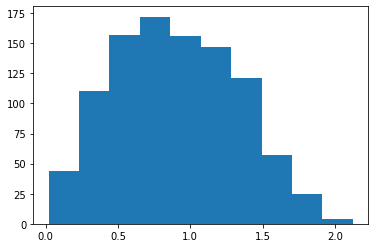

In [192]:
#no windfarms greater than 2 km distance as expected
plt.hist(dgrid_distances)

(array([14221.,     0.,     0., 65340.,     0.,     0., 39161.,     0.,
            0.,  7970.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

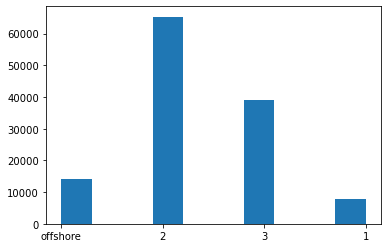

In [164]:
plt.hist(techno_df['power_curve'])

In [130]:
#all_wind_248 = np.load('../data/all-wind-1/wind/all_time0:248.npy')
all_wind = np.concatenate([
    np.load('../data/all-wind-1/wind/all_time0:248.npy'),
    np.load('../data/all-wind-1/wind/all_time248:992.npy')
])

In [131]:
all_wind.shape

(993, 61368)

In [165]:
imp.reload(power_curve)
import power_curve

,site_id,longitude,latitude,State,County,fraction_of_usable_area,power_curve,capacity,wind_speed,capacity_factor,full_timeseries_directory,full_timeseries_path
106451,106451,-70.871796,42.272900,Unknown,Unknown,1.0,offshore,16,7.74,0.351,212,212/106451.nc
92093,92093,-71.506317,41.097668,Unknown,Unknown,1.0,offshore,16,9.04,0.454,184,184/92093.nc
101183,101183,-71.371155,41.786667,Unknown,Unknown,1.0,offshore,16,6.16,0.215,202,202/101183.nc


In [168]:
pow_curve_all = np.array([np.mean(power_curve.get_power_curve_num(k)(windspeed_t))
                 for windspeed_t, k in zip(all_wind,wind_farm_techno_df['power_curve'])])

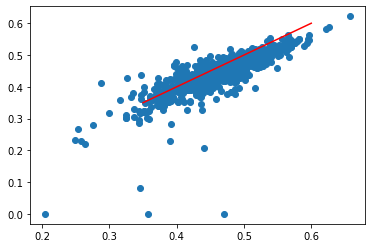

In [169]:
plt.scatter(pow_curve_all[~np.isnan(tidxs)],wind_farm_techno_df['capacity_factor'])
plt.plot([0.35,0.6],[0.35,0.6],c='red')

In [96]:
techno_df.head()

,site_id,longitude,latitude,State,County,fraction_of_usable_area,power_curve,capacity,wind_speed,capacity_factor,full_timeseries_directory,full_timeseries_path
0,0,-117.147260,23.510410,Unknown,Unknown,1.0,offshore,16,6.07,0.169,0,0/0.nc
1,1,-93.946777,24.007446,Unknown,Unknown,1.0,offshore,16,7.43,0.302,0,0/1.nc
2,2,-97.482483,25.069138,Unknown,Unknown,1.0,offshore,16,8.19,0.375,0,0/2.nc
3,3,-97.463135,25.069443,Unknown,Unknown,1.0,offshore,16,8.19,0.375,0,0/3.nc
4,4,-97.443756,25.069763,Unknown,Unknown,1.0,offshore,16,8.19,0.376,0,0/4.nc
